In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd

/content


In [3]:
import torch
import torchvision
import numpy as np
import pandas as pd

In [24]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

In [25]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [26]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [27]:
example_data.shape

torch.Size([1000, 1, 28, 28])

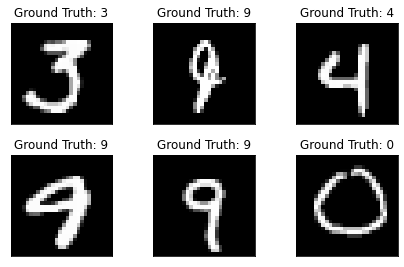

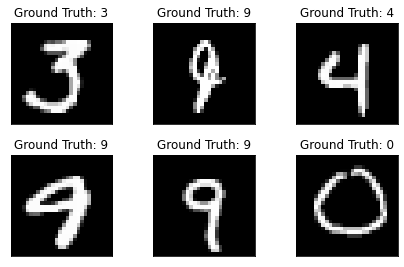

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [32]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [33]:
class Net(nn.Module):  #input grayscale image
    #output size formula [(W−K+2P)/S]+1
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # conv2d in_channels, out_channels, kernel_size,stride=1, padding=0,
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # maxpool2d torch.nn.MaxPool2d(kernel_size)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #32*32*1 -> 28*28*10->14*14*10
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #14*14*10->10*10*20->5*5*20 
        x = x.view(-1, 320)  #500->320
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [34]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [35]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [36]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

In [17]:
!mkdir results

In [37]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:

      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [38]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-33-6d2a1312227a>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.277653
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.304374
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.293264
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296668
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.273478
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.195527
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.223637
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.237352
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.144112
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.021623
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.737563
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.738520
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.776838
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.659537
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.495528
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.702995
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.327607
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.323891
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.051294
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.233832
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1863, Accuracy: 9467/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.650365
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.365386
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.542788
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.522186
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.510018
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.317506
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.367733
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.439160
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.520808
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.368461
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.352744
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.419952
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.307199
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.634961
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.331228
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.233605
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.437228
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.491084
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.448297
Train Epoch: 2 [12160

In [39]:
test()

<ipython-input-33-6d2a1312227a>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0706, Accuracy: 9785/10000 (98%)



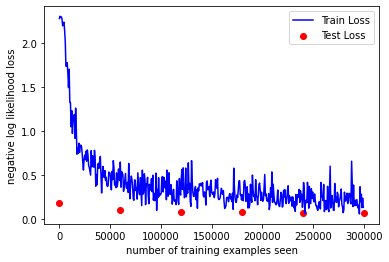

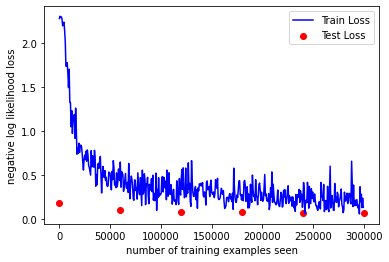

In [40]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [42]:
with torch.no_grad():
  output = network(example_data.to(device))

<ipython-input-33-6d2a1312227a>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


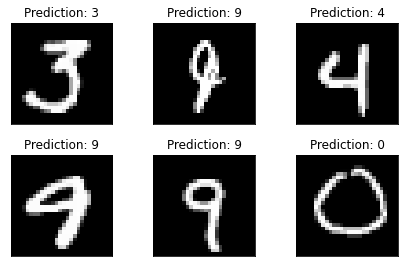

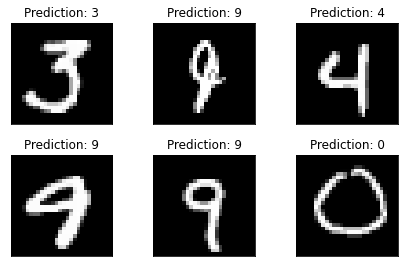

In [43]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [44]:
!mkdir /content/drive/MyDrive/colab_data/mnist_result

In [46]:
!cd /content/results && cp -r . /content/drive/MyDrive/colab_data/mnist_result/